# Data Generator Interval Analysis

This notebook reads the data generated by the data generator program and both sanity check it and post process it to generate BSP interval lengths that can be analyzed to understand and/or prediction application behavior.

## Time Breakdown of a Sample interval

Populating the interactive namespace from numpy and matplotlib
Maxes = 114475092, 114555664


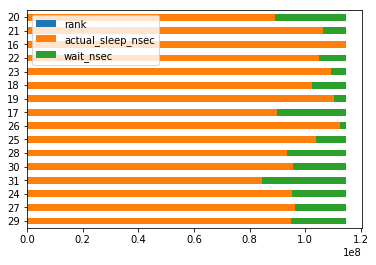

In [1]:
%pylab inline
import pandas as pd
import scipy

# 
df = pd.read_csv('../results/result.csv').sort_values(['uniq_id', 'iteration', 'rank'])

# First compute the interval lengths and subdivisions themselves - we have expected/actual sleep_nsec,
# so we need wait_nsec and interval_nsec just to make things easier.

df['wait_nsec'] = df.apply(lambda row: row.barrier_end - row.barrier_start, axis = 1)
df['interval_nsec'] = df.apply(lambda row: row.barrier_end - row.sleep_start, axis = 1)

# Finally compute the expected and actual maxes per iteration
exp_max = []
act_max = []
for frame in df.groupby(['iteration']):
    emax = frame[1]['expected_sleep_nsec'].max()
    amax = frame[1]['interval_nsec'].max()
    exp_max.append(emax)
    act_max.append(amax)
    
# Show an example iteration
i=1
df[df['iteration']==i][['rank', 'actual_sleep_nsec', 'wait_nsec']].plot.barh(stacked=True)
print('Maxes = {0}, {1}'.format(exp_max[i], act_max[i]))

## Sanity Check the Data from the Data Generator

The data generator program does a lot of things that *could* skew the statistics we're going to work with, so the first thing we're going to do is sanity check its data. In particular, we check that:
  1. The random samples the data generator uses for determining how long to sleep are drawn from the distribution it claims they're supposed to be drawn from and aren't skewed by random number generation or filtering, and
  1. The actual times that the data generator sleeps on each node are from the same distribution as the expected times to be slept, that is that our sleep mechanism isn't siginficantly skewing our numbers.
  1. The maximums of the expected times, finally, should fit a GEV distribution since they're literlly maximums of samples from the distributions we just checked above. We verify this basic GEV assumption.

In [2]:
from scipy import stats 
# First test that the the parallel random number generator in the
# data generator by looking at the running expected waits

# Get the distribution that the data generator used
distribution=df['distribution'][0]
distmap = { 'gaussian':'norm', 'exponential':'expon', 'uniform':'uniform', 'pareto':'pareto'}
scipydist = distmap[distribution]
a = df['mean'][0]*1000
b = df['std'][0]*1000

# First, are the full set of samples distributed as per requested
# the requested distribution, or is the data generator doing something
# that's skewing the data? For example, the data generator cuts off sleep times
# less than 0. If values less than zero would normally be a significant 
# portion of the distribution, for example gaussian with mean and standard 
# deviation near each other, this test could fail.
confidence = 0.05
(statistic, pvalue) = stats.kstest(df['expected_sleep_nsec'].ravel(), scipydist, (a, b))
if (pvalue < confidence):
    print('ERROR: Rejecting NULL Hypothesis that expected sleep values came from %s (%f, %f) with p=%f < %f' % (distribution, a, b, pvalue, confidence))
else:
    print('Expected sleep values came from %s (%f, %f) with p=%f > %f' % (distribution, a, b, pvalue, confidence))

# Next, test for the actual sleep values versus the expected sleep values. These
# skew slightly larger than the expected sleep values do to experimental problems so this
# test could fail particulalry for short wait times where this error is relatively 
# significant.
(statistic, pvalue) = stats.ks_2samp(df['expected_sleep_nsec'].ravel(), df['actual_sleep_nsec'].ravel())
if (pvalue < confidence):
    print('ERROR: Rejecting NULL Hypothesis that actual sleep values come from same distribution as expected sleep values with p=%f < %f' % (pvalue, confidence))
else:
    print('Actual and expected sleep values come from same distribution with p=%f > %f' % (pvalue, confidence))
    
# Finally, the expected maximums should be distributed as per an extreme value distribution, since
# they are the maximas of the distributions above
eparam = stats.genextreme.fit(exp_max)
statistic, pvalue = stats.kstest(exp_max, 'genextreme', args = eparam)
if (pvalue < confidence):
    print('ERROR: Rejecting NULL Hypothesis that expected interval lengths fit GEV {0} with p={1} < {2}'.format(eparam, pvalue, confidence))
else:
    print('Expected interval lengths come from GEV {0} with p={1} > {2}'.format(eparam, pvalue, confidence))

Expected sleep values came from gaussian (100000000.000000, 10000000.000000) with p=0.539258 > 0.050000
Actual and expected sleep values come from same distribution with p=1.000000 > 0.050000
ERROR: Rejecting NULL Hypothesis that expected interval lengths fit GEV (-13.045207246082185, 103519341.19410223, 2.532103787114056) with p=0.0 < 0.05


## Analysis of Actual Maximums

Now that we know that the basic data generator data is sane, we're going to start analyzing the actual maxima of intervals. These can be perturbed by the underlying system hardware (for example the system software on each node and the network which runs the barriers).

In [3]:
# First, do the actual maximums plausibly come from the same distribution as the expected maxima? 
# Note this ignores the time series nature of the data, but it's a good first test.
(statistic, pvalue) = stats.ks_2samp(exp_max, act_max)
if (pvalue < confidence):
    print('ERROR: Rejecting NULL Hypothesis that expected maxes come from same distribution as actual maxes with p=%f < %f' % (pvalue, confidence))
else:
    print('Actual and expected interval lengths come from same distribution with p=%f > %f' % (pvalue, confidence))
    
# Now fits of the actual maxima to the GEV distributio using maximum liklihood estimation
# Fit sample data to distribution

aparam = stats.genextreme.fit(act_max)
# Run the Kolmogorov-Smirnov test on the resulting distribution
statistic, pvalue = stats.kstest(act_max, 'genextreme', args = aparam)
if (pvalue < confidence):
    print('ERROR: Rejecting NULL Hypothesis that actual interval lengths fit GEV {0} with p={1} < {2}'.format(eparam, pvalue, confidence))
else:
    print('Actual interval lengths come from GEV {0} with p={1} > {2}'.format(eparam, pvalue, confidence))

Actual and expected interval lengths come from same distribution with p=1.000000 > 0.050000
ERROR: Rejecting NULL Hypothesis that actual interval lengths fit GEV (-13.045207246082185, 103519341.19410223, 2.532103787114056) with p=0.0 < 0.05
